### This section is to create annotations and labels file   

If working on kaggle else skip to create model.

In [1]:
# CREATE ANNOTATIONS AND LABELS FILE

import os
import csv
from xml.etree.ElementTree import Element, SubElement, tostring
from xml.dom.minidom import parseString

# Paths
output_dirs = {
    "flowering": "/kaggle/input/tomato-plant-dataset/Data/Flowering",
    "semi_ripe": "/kaggle/input/tomato-plant-dataset/Data/Fruiting/Half-Ripe",
    "ripe": "/kaggle/input/tomato-plant-dataset/Data/Fruiting/Ripe",
    "raw": "/kaggle/input/tomato-plant-dataset/Data/Fruiting/Raw"
}

annotations_dir = "/kaggle/working/Data/Annotations"
labels_csv_path = "/kaggle/working/Data/labels.csv"

# Ensure annotations directory exists
os.makedirs(annotations_dir, exist_ok=True)
print(f"Created directory at {annotations_dir}.")

# Open CSV file for writing
csv_file = open(labels_csv_path, mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['filename', 'label'])  # CSV header

# Function to create annotation files
def create_annotation(image_name, category, bbox, image_size, output_dir):
    annotation = Element("annotation")
    folder = SubElement(annotation, "folder")
    folder.text = category

    filename = SubElement(annotation, "filename")
    filename.text = image_name

    size = SubElement(annotation, "size")
    width = SubElement(size, "width")
    height = SubElement(size, "height")
    depth = SubElement(size, "depth")
    width.text, height.text, depth.text = map(str, image_size)

    obj = SubElement(annotation, "object")
    name = SubElement(obj, "name")
    name.text = category

    bndbox = SubElement(obj, "bndbox")
    xmin, ymin, xmax, ymax = bbox
    SubElement(bndbox, "xmin").text = str(xmin)
    SubElement(bndbox, "ymin").text = str(ymin)
    SubElement(bndbox, "xmax").text = str(xmax)
    SubElement(bndbox, "ymax").text = str(ymax)

    # Save annotation
    annotation_file = os.path.join(output_dir, image_name.replace('.jpg', '.xml'))
    dom = parseString(tostring(annotation))
    with open(annotation_file, "w") as f:
        f.write(dom.toprettyxml(indent="  "))
    #print(f"Saved annotation: {annotation_file}")

# Generate annotations and CSV entries
for category, category_dir in output_dirs.items():
    for img_name in os.listdir(category_dir):
        if not img_name.endswith('.jpg'):
            continue

        # Simulated bounding box (centered)
        image_size = (224, 224, 3)
        h, w = image_size[:2]
        xmin, ymin = w // 4, h // 4
        xmax, ymax = 3 * w // 4, 3 * h // 4

        # Save annotation
        create_annotation(
            image_name=img_name,
            category=category,
            bbox=[xmin, ymin, xmax, ymax],
            image_size=image_size,
            output_dir=annotations_dir
        )

        # Add entry to CSV with absolute paths
        csv_writer.writerow([os.path.abspath(os.path.join(category_dir, img_name)), category])

# Close CSV file
csv_file.close()
print(f"Labels CSV saved to: {labels_csv_path}")

Created directory at /kaggle/working/Data/Annotations.
Labels CSV saved to: /kaggle/working/Data/labels.csv


* Best results obtained with: Epochs= 30, Batch-size= 32

In [2]:
# import libraries

import os
import random
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.model_selection import cross_val_predict
import tensorflow as tf

In [3]:
# Paths

labels_csv_path = "/kaggle/working/Data/labels.csv"         # path of the csv file 

img_size = (224, 224)

In [4]:
# Preprocessing function

def preprocess_image(img_path, img_size=(224, 224)):
    img = cv.imread(img_path)
    if img is None:
        print(f"Error reading image: {img_path}")
        return None
    img = cv.resize(img, img_size)       # resize image
    img = img / 255.0                    # normalize image
    return img

In [5]:
# Dataset loader

def load_dataset_from_csv(csv_path, img_size=(224, 224)):                 
    data = pd.read_csv(csv_path)
    images, labels = [], []
    for _, row in data.iterrows():
        img = preprocess_image(row['filename'], img_size)
        if img is not None:
            images.append(img)
            labels.append(row['label'])
    print(f"Successfully loaded {len(images)} images.")
    return np.array(images), np.array(labels)

# Load data
images, labels = load_dataset_from_csv(labels_csv_path)

# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
labels = np.array([label_to_index[label] for label in labels])
labels = to_categorical(labels, num_classes=len(label_to_index))

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Successfully loaded 3600 images.
Training samples: 2880, Validation samples: 720


In [6]:
# Data Augmentation for Training

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [7]:
# Use MobileNetV2 as the base model

def create_model(input_shape=(224, 224, 3), num_classes=len(label_to_index)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False   # Freeze base layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')   # Multi-class classification
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callbacks

checkpoint = ModelCheckpoint('/kaggle/working/Models/tomato_classifier_model.keras', 
                             save_best_only=True, verbose=1)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
# Train the model

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.5357 - loss: 1.1204
Epoch 1: val_loss improved from inf to 0.46009, saving model to /kaggle/working/Models/tomato_classifier_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5370 - loss: 1.1171 - val_accuracy: 0.8222 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7810 - loss: 0.5370
Epoch 2: val_loss improved from 0.46009 to 0.32729, saving model to /kaggle/working/Models/tomato_classifier_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7811 - loss: 0.5367 - val_accuracy: 0.8681 - val_loss: 0.3273 - learning_rate: 0.0010
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.8169 - loss: 0.4414
Epoch 3: val_loss improved from 0.32729 to 0.30586, saving model to /kaggle/working/Models/tomato_classifier_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8169 - loss: 0.4415 - val_accuracy: 0.8819 - val_loss: 0.3059 -

In [10]:
# Evaluate the model

scores = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {scores[1] * 100:.2f}%, Validation Loss: {scores[0] * 100:.2f}%")

Validation Accuracy: 92.64%, Validation Loss: 18.09%


In [11]:
# Classification report and confusion matrix

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_to_index.keys())))

23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 832ms/step

Classification Report:
              precision    recall  f1-score   support

   flowering       1.00      1.00      1.00       204
         raw       0.92      0.95      0.94       170
        ripe       0.87      0.90      0.88       165
   semi_ripe       0.91      0.85      0.88       181

    accuracy                           0.93       720
   macro avg       0.92      0.92      0.92       720
weighted avg       0.93      0.93      0.93       720



In [12]:
# Precision, Recall and F1 scores

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.93
Recall: 0.93
F1 Score: 0.93


In [13]:
# Directory to save Figures

fdir = "/kaggle/working/Figures"
os.makedirs(fdir, exist_ok=True)
print(f"Created directory at {fdir}.")

Created directory at /kaggle/working/Figures.


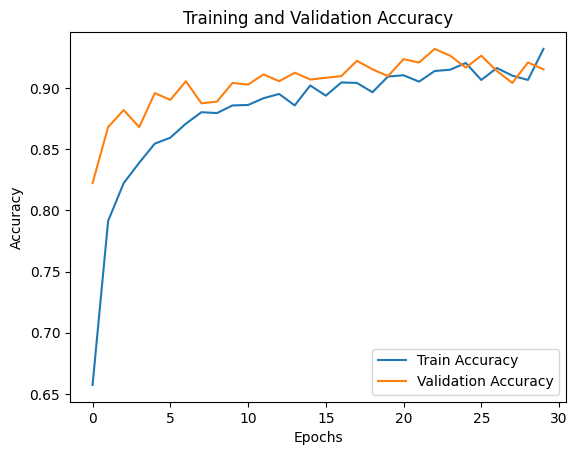

In [14]:
# Plot training history

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

try:
    plt.savefig(os.path.join(fdir, "train_val_accuracy.jpg"))
except:
    print("Some error occurred while trying to save the Training and Validation Accuracy plot image!")

plt.show()

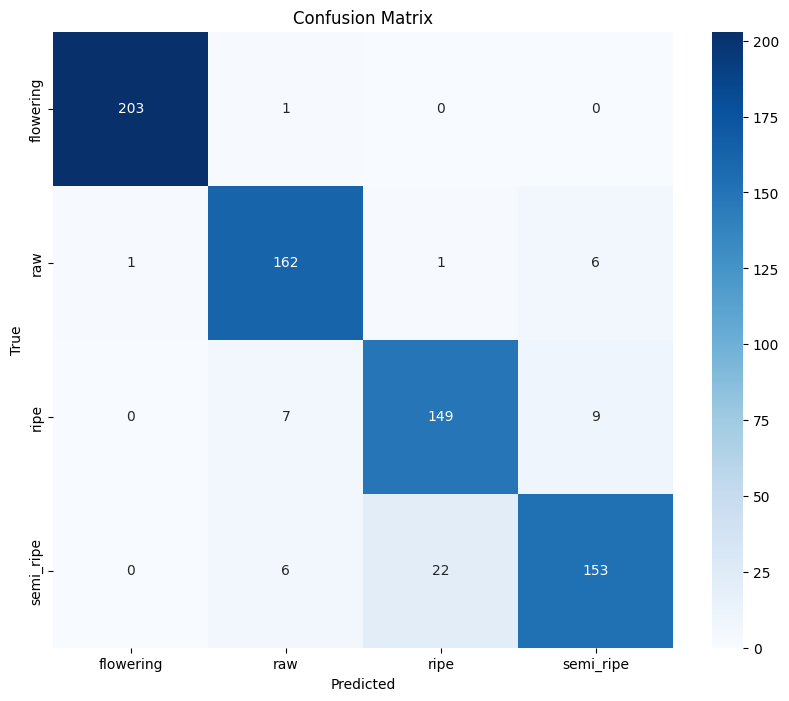

In [15]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(),yticklabels=label_to_index.keys())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

try:
    plt.savefig(os.path.join(fdir, "confusion-matrix.jpg"))
except:
    print("Some error occurred while trying to save the Confusion Matrix plot image!")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Label: flowering with confidence of 0.98


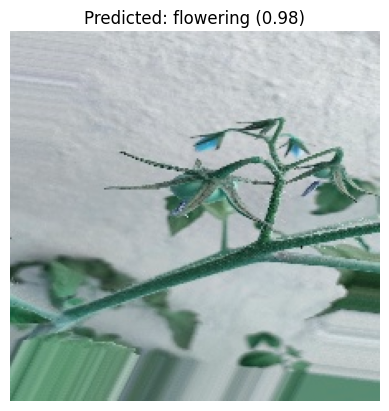

In [ ]:
# Prediction Function

def predict_image(model, img_path, img_size=(224, 224)):
    img = preprocess_image(img_path, img_size)
    if img is None:
        return "Error reading image"
    expanded_img = np.expand_dims(img, axis=0)
    prediction = model.predict(expanded_img)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]
    predicted_label = index_to_label[class_idx]
    print(f"Predicted Label: {predicted_label} with confidence of {confidence:.2f}")
    
    # Display the image with prediction as title
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f})")
    plt.axis('off')
    plt.show()
    

# Predict an image

img_path = "/kaggle/input/tomato-plant-dataset/Data/Flowering/flowering_620.jpg"
predict_image(model, img_path)

In [ ]:
# Save model

model.save("/kaggle/working/Models/growth_stage_classifier.keras")
print("Model saved as growth_stage_classifier.keras")

Model saved as growth_stage_classifier.keras
